In [1]:
import os
import numpy as np
from skimage import io
from matplotlib import pyplot as plt
from scipy.misc import imresize
from scipy import ndimage

%matplotlib inline

import tensorflow as tf
from keras.layers import Dense, Activation, Flatten, Lambda, BatchNormalization, Reshape
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D, UpSampling2D
from keras.engine import merge, Input, Model
from keras.optimizers import SGD
from keras.callbacks import Callback, LearningRateScheduler, ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
import keras.backend as K
import time
import random
import pickle
import json
import csv
from tqdm import tqdm
from natsort import natsorted

from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

from helper import to_rle
from segmentation import *
from stochastic_depth_resnet import *

DATADIR = os.path.expanduser('~/data/kaggle/ultrasound-nerve-segmentation')
PROCDIR = os.path.expanduser('~/ml/kaggle/ultrasound-nerve-segmentation/processed')
MODELDIR = os.path.expanduser('~/ml/kaggle/ultrasound-nerve-segmentation/models')
SUBMITDIR = os.path.expanduser('~/ml/kaggle/ultrasound-nerve-segmentation/submissions')

Using TensorFlow backend.


In [2]:
PRESENCE_WEIGHTS_FILEPATH_A = os.path.join(MODELDIR, 'model-presence-17a-weights.hdf5')
PRESENCE_WEIGHTS_FILEPATH_B = os.path.join(MODELDIR, 'model-presence-17b-weights.hdf5')
PRESENCE_WEIGHTS_FILEPATH_C = os.path.join(MODELDIR, 'model-presence-17c-weights.hdf5')

VAE_WEIGHTS_FILEPATH_A = os.path.join(MODELDIR, 'model-vae-17a-weights.hdf5')
VAE_WEIGHTS_FILEPATH_B = os.path.join(MODELDIR, 'model-vae-17b-weights.hdf5')
VAE_WEIGHTS_FILEPATH_C = os.path.join(MODELDIR, 'model-vae-17c-weights.hdf5')

SEGMENT_WEIGHTS_FILEPATH_A = os.path.join(MODELDIR, 'model-segment-17a-weights.hdf5')
SEGMENT_WEIGHTS_FILEPATH_B = os.path.join(MODELDIR, 'model-segment-17b-weights.hdf5')
SEGMENT_WEIGHTS_FILEPATH_C = os.path.join(MODELDIR, 'model-segment-17c-weights.hdf5')

In [3]:
with open(os.path.join(PROCDIR, 'train_files_map.pkl'), 'rb') as f:
    train_files_map = pickle.load(f)
with open(os.path.join(PROCDIR, 'test_files_map.pkl'), 'rb') as f:
    test_files_map = pickle.load(f)
with open(os.path.join(PROCDIR, 'conflicting_17.pkl'), 'rb') as f:
    conflicting = pickle.load(f)
    
keys_sorted = natsorted(list(train_files_map.keys()))

## segmentation model

In [4]:
with open(os.path.join(PROCDIR, 'data_train_val_segment_17a.pkl'), 'rb') as f:
    data_images_train, data_masks_train, data_images_val, data_masks_val = pickle.load(f)
    
print('image shapes:', data_images_train.shape, data_images_val.shape)
print('mask shapes:', data_masks_train.shape, data_masks_val.shape)

image shapes: (30936, 96, 128, 1) (479, 96, 128, 1)
mask shapes: (30936, 96, 128) (479, 96, 128)


In [5]:
with tf.device('/gpu:0'):
    
    start_time = time.time()

    orig_img_rows, orig_img_cols = 420, 580
    img_rows, img_cols = 96, 128
    img_channels = 1

    blocks_per_group = 2
    nb_total_blocks = 4 * blocks_per_group
    
    images = Input(shape=(img_rows, img_cols, img_channels))

    x = Convolution2D(4, 3, 3, subsample=(1, 1),
                      init='he_normal', border_mode='same', dim_ordering='tf')(images)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    for i in range(0, blocks_per_group):
        nb_filters = 4
        x = stochastic_depth_residual_block(x, nb_filters=nb_filters,
                                            block=i, nb_total_blocks=nb_total_blocks,
                                            subsample_factor=1)

    for i in range(0, blocks_per_group):
        nb_filters = 8
        if i == 0:
            subsample_factor = 2
        else:
            subsample_factor = 1
        x = stochastic_depth_residual_block(x, nb_filters=nb_filters,
                                            block=blocks_per_group + i, nb_total_blocks=nb_total_blocks,
                                            subsample_factor=subsample_factor)

    f2 = x
    f2 = UpSampling2D(size=(2, 2), dim_ordering='tf')(f2)
    f2 = Convolution2D(4, 3, 3, init='he_uniform', border_mode='same', activation='relu', dim_ordering='tf')(f2)

    for i in range(0, blocks_per_group):
        nb_filters = 16
        if i == 0:
            subsample_factor = 2
        else:
            subsample_factor = 1
        x = stochastic_depth_residual_block(x, nb_filters=nb_filters,
                                            block=2 * blocks_per_group + i, nb_total_blocks=nb_total_blocks,
                                            subsample_factor=subsample_factor)

    f4 = x
    f4 = UpSampling2D(size=(4, 4), dim_ordering='tf')(f4)
    f4 = Convolution2D(4, 3, 3, init='he_uniform', border_mode='same', activation='relu', dim_ordering='tf')(f4)

    for i in range(0, blocks_per_group):
        nb_filters = 32
        if i == 0:
            subsample_factor = 2
        else:
            subsample_factor = 1
        x = stochastic_depth_residual_block(x, nb_filters=nb_filters,
                                            block=3 * blocks_per_group + i, nb_total_blocks=nb_total_blocks,
                                            subsample_factor=subsample_factor)

    f8 = x
    f8 = UpSampling2D(size=(8, 8), dim_ordering='tf')(f8)
    f8 = Convolution2D(4, 3, 3, init='he_uniform', border_mode='same', activation='relu', dim_ordering='tf')(f8)

    segmentation = merge([f8, f4, f2], mode='concat', concat_axis=-1)
    segmentation = Convolution2D(1, 1, 1, 
                                 activation='sigmoid', 
                                 init='uniform', border_mode='same', dim_ordering='tf')(segmentation)
    segmentation = Reshape((img_rows, img_cols))(segmentation)

    model = Model(input=images, output=segmentation)

    print('model init time: {}'.format(time.time() - start_time))

    start_time = time.time()

    model.compile(optimizer='adam',
                  loss=binaryCE,
                  metrics=[dice_coeff])

    print('model compile time: {}'.format(time.time() - start_time))

model init time: 4.4100117683410645
model compile time: 0.25975489616394043


In [6]:
batch_size = 128
nb_epoch = 3

# Model saving callback
#checkpointer = ModelCheckpoint(filepath=WEIGHTS_FILEPATH, monitor='val_dice_coeff', verbose=1, save_best_only=True, mode='max')

# Early stopping
#early_stopping = EarlyStopping(monitor='val_dice_coeff', patience=10, mode='max')

history = model.fit(data_images_train, data_masks_train,
                    batch_size=batch_size, nb_epoch=nb_epoch, verbose=1,
                    validation_data=(data_images_val, data_masks_val), shuffle=True,
                    callbacks=[])

#with open(HISTORY_FILEPATH, 'w') as f_out:
#    json.dump(history.history, f_out)

Train on 30936 samples, validate on 479 samples
Epoch 1/3
30936/30936 [==============================] - 67s - loss: 0.1585 - dice_coeff: 0.0029 - val_loss: 0.1104 - val_dice_coeff: 3.0992e-05
Epoch 2/3
30936/30936 [==============================] - 64s - loss: 0.0823 - dice_coeff: 0.0886 - val_loss: 0.0875 - val_dice_coeff: 0.0440
Epoch 3/3
30936/30936 [==============================] - 64s - loss: 0.0665 - dice_coeff: 0.3025 - val_loss: 0.0654 - val_dice_coeff: 0.3360


## test

In [6]:
model.load_weights(WEIGHTS_FILEPATH_A)

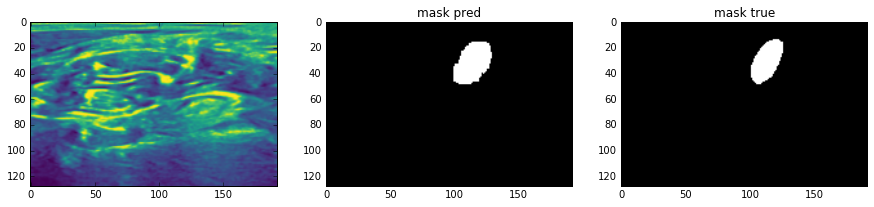

In [50]:
rand_i = random.randint(0, data_images_val.shape[0] - 1)
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(data_images_val[rand_i, :, :, 0], cmap=plt.cm.viridis)
plt.subplot(1,3,2)
plt.title('mask pred')
plt.imshow(model.predict(data_images_val[rand_i:rand_i+1], verbose=0)[0, :, :] > 0.5, cmap=plt.cm.bone)
plt.subplot(1,3,3)
plt.title('mask true')
plt.imshow(data_masks_val[rand_i, :, :], cmap=plt.cm.bone)

## with vae

In [23]:
batch_size = 1
img_rows, img_cols = 192, 256
img_channels = 1

latent_dim = 10
epsilon_std = 0.001
nb_epoch = 300

masks = Input(batch_shape=(batch_size, img_rows, img_cols))

x_encoder = Reshape((img_rows, img_cols, img_channels), input_shape=(img_rows, img_cols))(masks)
x_encoder = Convolution2D(8, 3, 3, subsample=(1, 1), init='he_normal', activation='relu', 
                          border_mode='same', dim_ordering='tf')(x_encoder)
x_encoder = Convolution2D(8, 3, 3, subsample=(1, 1), init='he_normal', activation='relu', 
                          border_mode='same', dim_ordering='tf')(x_encoder)
x_encoder = MaxPooling2D(pool_size=(2, 2), border_mode='valid', dim_ordering='tf')(x_encoder)
x_encoder = Convolution2D(16, 3, 3, subsample=(1, 1), init='he_normal', activation='relu', 
                          border_mode='same', dim_ordering='tf')(x_encoder)
x_encoder = Convolution2D(16, 3, 3, subsample=(1, 1), init='he_normal', activation='relu', 
                          border_mode='same', dim_ordering='tf')(x_encoder)
x_encoder = MaxPooling2D(pool_size=(2, 2), border_mode='valid', dim_ordering='tf')(x_encoder)
x_encoder = Convolution2D(32, 3, 3, subsample=(1, 1), init='he_normal', activation='relu', 
                          border_mode='same', dim_ordering='tf')(x_encoder)
x_encoder = Convolution2D(32, 3, 3, subsample=(1, 1), init='he_normal', activation='relu', 
                          border_mode='same', dim_ordering='tf')(x_encoder)
x_encoder = MaxPooling2D(pool_size=(2, 2), border_mode='valid', dim_ordering='tf')(x_encoder)
x_encoder = Flatten()(x_encoder)

z_mean = Dense(latent_dim)(x_encoder)
z_log_std = Dense(latent_dim)(x_encoder)

def sampling(args):
    z_mean, z_log_std = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0., std=epsilon_std)
    return z_mean + K.exp(z_log_std) * epsilon

z = Lambda(sampling)([z_mean, z_log_std])

x_decoder = Dense(12 * 16, activation='relu')(z)
x_decoder = Reshape((12, 16, 1))(x_decoder)
x_decoder = UpSampling2D(size=(2, 2), dim_ordering='tf')(x_decoder)
x_decoder = Convolution2D(32, 3, 3, subsample=(1, 1), init='he_normal', activation='relu', 
                          border_mode='same', dim_ordering='tf')(x_decoder)
x_decoder = Convolution2D(32, 3, 3, subsample=(1, 1), init='he_normal', activation='relu', 
                          border_mode='same', dim_ordering='tf')(x_decoder)
x_decoder = UpSampling2D(size=(2, 2), dim_ordering='tf')(x_decoder)
x_decoder = Convolution2D(16, 3, 3, subsample=(1, 1), init='he_normal', activation='relu', 
                          border_mode='same', dim_ordering='tf')(x_decoder)
x_decoder = Convolution2D(16, 3, 3, subsample=(1, 1), init='he_normal', activation='relu', 
                          border_mode='same', dim_ordering='tf')(x_decoder)
x_decoder = UpSampling2D(size=(2, 2), dim_ordering='tf')(x_decoder)
x_decoder = Convolution2D(8, 3, 3, subsample=(1, 1), init='he_normal', activation='relu', 
                          border_mode='same', dim_ordering='tf')(x_decoder)
x_decoder = Convolution2D(8, 3, 3, subsample=(1, 1), init='he_normal', activation='relu', 
                          border_mode='same', dim_ordering='tf')(x_decoder)

x_decoded_mean = Convolution2D(1, 1, 1, activation='sigmoid', 
                               init='uniform', border_mode='same', dim_ordering='tf')(x_decoder)
x_decoded_mean = Reshape((img_rows, img_cols))(x_decoded_mean)

def vae_loss(masks, x_decoded_mean):
    xent_loss = objectives.binary_crossentropy(masks, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_std - K.square(z_mean) - K.exp(z_log_std), axis=None, keepdims=False)
    return xent_loss + kl_loss

vae = Model(masks, x_decoded_mean)

vae.load_weights(os.path.join(MODELDIR, 'model-vae-16-weights.hdf5'))

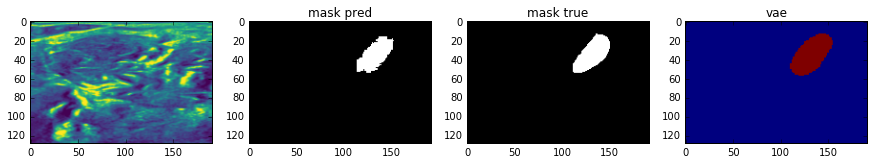

In [55]:
rand_i = random.randint(0, data_images_val.shape[0] - 1)
plt.figure(figsize=(15,5))
plt.subplot(1,4,1)
plt.imshow(data_images_val[rand_i, :, :, 0], cmap=plt.cm.viridis)
plt.subplot(1,4,2)
plt.title('mask pred')
mask_pred = model.predict(data_images_val[rand_i:rand_i+1], verbose=0)[0, :, :] > 0.5
plt.imshow(mask_pred, cmap=plt.cm.bone)
plt.subplot(1,4,3)
plt.title('mask true')
plt.imshow(data_masks_val[rand_i, :, :], cmap=plt.cm.bone)
plt.subplot(1,4,4)
plt.title('vae')
mask_vae = vae.predict_on_batch(np.array([imresize(mask_pred, size=(96,128), interp='bilinear').astype(np.bool)], dtype=np.bool))[0] > 0.5
plt.imshow(imresize(mask_vae, size=(128, 192), interp='bilinear').astype(np.bool))

## submission

In [67]:
model.load_weights(WEIGHTS_FILEPATH_A)
preds_a = model.predict(data_images_val, verbose=0)
model.load_weights(WEIGHTS_FILEPATH_B)
preds_b = model.predict(data_images_val, verbose=0)
model.load_weights(WEIGHTS_FILEPATH_C)
preds_c = model.predict(data_images_val, verbose=0)
preds = (preds_a + preds_b + preds_c) / 3
preds_vae = []
for i in tqdm(range(len(preds))):
    mask_pred = preds[i] > 0.5
    pred_vae = vae.predict_on_batch(np.array([imresize(mask_pred, size=(96,128), interp='bilinear').astype(np.bool)], dtype=np.bool))[0] > 0.5
    preds_vae.append(imresize(pred_vae, size=(128, 192), interp='bilinear').astype(np.bool))
preds_vae = np.array(preds_vae, dtype=np.bool)
np.mean((2 * np.sum(data_masks_val * preds_vae) + 1) / (np.sum(data_masks_val) + np.sum(preds_vae) + 1), axis=None)

100%|██████████| 480/480 [00:02<00:00, 234.65it/s]


0.72203478659635101

In [68]:
img_rows, img_cols = 128, 192

images_resized = {}
for key in tqdm(natsorted(list(test_files_map.keys()))):
    file_info = test_files_map[key]
    img, folder, img_file = file_info['img'], file_info['folder'], file_info['img_file']
    img_filepath = os.path.join(folder, img_file)
    image = io.imread(img_filepath) / 255.0
    image_resized = np.expand_dims(imresize(image, size=(img_rows, img_cols), interp='bilinear'), axis=3)
    images_resized[key] = image_resized

preds_a = {}
model.load_weights(WEIGHTS_FILEPATH_A)
for key in tqdm(natsorted(list(test_files_map.keys()))):
    image_resized = images_resized[key]
    pred_a = model.predict(np.array([image_resized], dtype=np.float32), verbose=0)[0, :, :]
    preds_a[key] = pred_a

preds_b = {}
model.load_weights(WEIGHTS_FILEPATH_B)
for key in tqdm(natsorted(list(test_files_map.keys()))):
    image_resized = images_resized[key]
    pred_b = model.predict(np.array([image_resized], dtype=np.float32), verbose=0)[0, :, :]
    preds_b[key] = pred_b

preds_c = {}
model.load_weights(WEIGHTS_FILEPATH_C)
for key in tqdm(natsorted(list(test_files_map.keys()))):
    image_resized = images_resized[key]
    pred_c = model.predict(np.array([image_resized], dtype=np.float32), verbose=0)[0, :, :]
    preds_c[key] = pred_c
        
        
with open(os.path.join(SUBMITDIR, 'model-15-abc-vae.csv'), 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['img', 'pixels'])
    
    for key in tqdm(natsorted(list(test_files_map.keys()))):
        file_info = test_files_map[key]
        img, folder, img_file = file_info['img'], file_info['folder'], file_info['img_file']
        pred_a, pred_b, pred_c = preds_a[key], preds_b[key], preds_c[key]
        pred = (pred_a + pred_b + pred_c) / 3
        mask_pred = pred > 0.5
        mask_pred_vae = vae.predict_on_batch(np.array([imresize(mask_pred, size=(96,128), interp='bilinear').astype(np.bool)], dtype=np.bool))[0] > 0.5
        mask_pred_orig_size = imresize(mask_pred_vae, size=(orig_img_rows, orig_img_cols), interp='bilinear').astype(np.bool)
        rle = to_rle(mask_pred_orig_size)
        writer.writerow([img, rle])

 11%|█         | 592/5508 [00:12<01:38, 49.83it/s]/home/leon/install/miniconda3/lib/python3.5/site-packages/skimage/external/tifffile/tifffile.py:1794: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)
100%|██████████| 5508/5508 [01:16<00:00, 71.94it/s]
